In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d 'soumikrakshit/anime-faces'
!unzip anime-faces.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/data/552.png       

# ***MODEL_1***

In [ ]:
# Import required libraries and tools
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Conv2DTranspose,
    Reshape,
    BatchNormalization,
    Dropout,
    ReLU,
    LeakyReLU,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Parameters
img_width, img_height = 64, 64
batch_size = 64
input_dim = 300  # Latent space dimension
epochs = 45
lr_g = 0.00015
lr_d = 0.0001
beta = 0.5
dataset_dir = "/content/data/data"  # Update with your dataset directory
save_dir = "/content/drive/MyDrive/generated_images/"  # Directory to save generated images
weights_save_dir = "/content/drive/MyDrive/model_weights/"  # Directory to save model weights
model_save_dir = "/content/drive/MyDrive/saved_models/"  # Directory to save complete models

# Ensure all save directories exist
for directory in [save_dir, weights_save_dir, model_save_dir]:
    os.makedirs(directory, exist_ok=True)

# Function to visualize dataset
def visualize_dataset(dataset):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(dataset[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('dataset_samples.png')
    plt.close()



def plot_convergence(history):
    plt.figure(figsize=(12, 4))
    plt.title("Model Convergence At 55 Epochs")
    plt.subplot(1, 2, 1)
    plt.plot(history.history['d_loss'], label='Discriminator Loss')
    plt.title('Discriminator Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['g_loss'], label='Generator Loss')
    plt.title('Generator Loss')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/convergence_plot.png")
    plt.close()
# Weight Saving Callback
class WeightSavingCallback(keras.callbacks.Callback):
    def __init__(self, save_dir="/content/drive/MyDrive/model_weights", prefix="dcgan"):
        super().__init__()
        self.save_dir = save_dir
        self.prefix = prefix
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        epoch_str = f"{epoch + 56:03d}"

        # Save generator weights
        generator_path = os.path.join(
            self.save_dir,
            f"{self.prefix}_generator_weights_epoch_{epoch_str}.weights.h5"
        )
        self.model.generator.save_weights(generator_path)
        print(f"Saved generator weights to {generator_path}")

        # Save discriminator weights
        discriminator_path = os.path.join(
            self.save_dir,
            f"{self.prefix}_discriminator_weights_epoch_{epoch_str}.weights.h5"
        )
        self.model.discriminator.save_weights(discriminator_path)
        print(f"Saved discriminator weights to {discriminator_path}")

# Function to load images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith((".png", ".jpg", ".jpeg")):  # Valid image formats
            img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img = keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

# Load images into memory
dataset = load_images_from_folder(dataset_dir, target_size=(img_width, img_height))
print(f"Loaded {len(dataset)} images from {dataset_dir}")
visualize_dataset(dataset)
# Convert dataset to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(buffer_size=1024).batch(batch_size)

# Generator Model
def Generator_Model():
    generator = Sequential()
    generator.add(Dense(8 * 8 * 512, input_dim=input_dim))
    generator.add(ReLU())
    generator.add(Reshape((8, 8, 512)))
    generator.add(
        Conv2DTranspose(
            256,
            (4, 4),
            strides=(2, 2),
            padding="same",
            kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
        )
    )
    generator.add(ReLU())
    generator.add(
        Conv2DTranspose(
            128,
            (4, 4),
            strides=(2, 2),
            padding="same",
            kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
        )
    )
    generator.add(ReLU())
    generator.add(
        Conv2DTranspose(
            64,
            (4, 4),
            strides=(2, 2),
            padding="same",
            kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
        )
    )
    generator.add(ReLU())
    generator.add(Conv2D(3, (4, 4), padding="same", activation="sigmoid"))
    return generator

# Discriminator Model
def Discriminator_Model():
    input_shape = (img_width, img_height, 3)
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (4, 4), strides=(2, 2), padding="same", input_shape=input_shape))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Conv2D(128, (4, 4), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Conv2D(256, (4, 4), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))
    return discriminator

# Callback to save generated images
class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=input_dim, save_dir=save_dir):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        self.save_dir = save_dir
        self.noise = tf.random.normal([num_imgs, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.noise, training=False)
        generated_images = (generated_images * 255).numpy().astype("uint8")
        plt.figure(figsize=(10, 10))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i + 1)
            plt.imshow(generated_images[i])
            plt.axis("off")
        plt.savefig(f"{self.save_dir}/generated_epoch_{epoch + 56}.png")
        plt.close()

# Define DCGAN Model
class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim=input_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train discriminator
        with tf.GradientTape() as tape:
            real_labels = tf.ones((batch_size, 1)) + 0.05 * tf.random.uniform((batch_size, 1))
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(real_labels, pred_real)

            fake_images = self.generator(random_noise)
            fake_labels = tf.zeros((batch_size, 1))
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            d_loss = (d_loss_real + d_loss_fake) / 2

        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        # Train generator
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)

        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

# Function to save complete models
def save_complete_models(generator, discriminator, dcgan, save_dir):
    """
    Save complete generator, discriminator, and DCGAN models

    Args:
        generator (keras.Model): Trained generator model
        discriminator (keras.Model): Trained discriminator model
        dcgan (keras.Model): Trained DCGAN model
        save_dir (str): Directory to save models
    """
    # Ensure save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Save generator model
    generator_path = os.path.join(save_dir, "complete_generator2_model.h5")
    generator.save(generator_path)
    print(f"Complete generator model saved to {generator_path}")

    # Save discriminator model
    discriminator_path = os.path.join(save_dir, "complete_discriminator2_model.h5")
    discriminator.save(discriminator_path)
    print(f"Complete discriminator model saved to {discriminator_path}")

    # Save the entire DCGAN model
    dcgan_path = os.path.join(save_dir, "complete_dcgan2_model.h5")
    dcgan.save(dcgan_path)
    print(f"Complete DCGAN model saved to {dcgan_path}")

# Function to load the weights of Generator and Discriminator
def load_model_weights(generator, discriminator, generator_weights_path, discriminator_weights_path):
    """
    Load the weights for the Generator and Discriminator models from the specified paths.

    Args:
        generator (keras.Model): Generator model
        discriminator (keras.Model): Discriminator model
        generator_weights_path (str): Path to the saved generator weights
        discriminator_weights_path (str): Path to the saved discriminator weights
    """
    # Load the generator weights
    if os.path.exists(generator_weights_path):
        generator.load_weights(generator_weights_path)
        print(f"Loaded generator weights from {generator_weights_path}")
    else:
        print(f"Generator weights not found at {generator_weights_path}")

    # Load the discriminator weights
    if os.path.exists(discriminator_weights_path):
        discriminator.load_weights(discriminator_weights_path)
        print(f"Loaded discriminator weights from {discriminator_weights_path}")
    else:
        print(f"Discriminator weights not found at {discriminator_weights_path}")

# Specify the paths to the saved weights
generator_weights_path = "/content/drive/MyDrive/model_weights/dcgan_generator_weights_epoch_055.weights.h5"  # Update with the correct path
discriminator_weights_path = "/content/drive/MyDrive/model_weights/dcgan_discriminator_weights_epoch_055.weights.h5"  # Update with the correct path

print("\nGenerator Model Summary:")
generator = Generator_Model()
generator.summary()

# Print Discriminator Summary
print("\nDiscriminator Model Summary:")
discriminator = Discriminator_Model()
discriminator.summary()


# Load the models and their weights
generator = Generator_Model()
discriminator = Discriminator_Model()
load_model_weights(generator, discriminator, generator_weights_path, discriminator_weights_path)
# After loading the dataset, add dataset visualization

# Existing training code for DCGAN
dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=input_dim)
dcgan.compile(
    g_optimizer=Adam(learning_rate=lr_g, beta_1=beta),
    d_optimizer=Adam(learning_rate=lr_d, beta_1=beta),
    loss_fn=BinaryCrossentropy(),
)

# Train the DCGAN model
history = dcgan.fit(
    train_dataset,
    epochs=epochs,
    callbacks=[
        DCGANMonitor(),
        WeightSavingCallback(save_dir=weights_save_dir),
    ]
)


# Plot Losses
def create_loss_figure(history):
    d_loss_values = history.history["d_loss"]
    g_loss_values = history.history["g_loss"]
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_values, label="Discriminator Loss")
    plt.plot(g_loss_values, label="Generator Loss")
    plt.title("Generator and Discriminator Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{save_dir}/loss_plot2.png")
    plt.close()
# Plot Losses and Convergence
create_loss_figure(history)
plot_convergence(history)

# Save the trained models

# Save the trained models
save_complete_models(generator, discriminator, dcgan, model_save_dir)


Loaded 21551 images from /content/data/data

Generator Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       9,863,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,619,203 (48.14 MB)

 Trainable params: 12,619,203 (48.14 MB)

 Non-trainable params: 0 (0.00 B)


Discriminator Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 675,265 (2.58 MB)

 Trainable params: 675,265 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Loaded generator weights from /content/drive/MyDrive/model_weights/dcgan_generator_weights_epoch_025.weights.h5
Loaded discriminator weights from /content/drive/MyDrive/model_weights/dcgan_discriminator_weights_epoch_025.weights.h5
Epoch 1/25
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - d_loss: 0.6488 - g_loss: 0.8658Saved generator weights to /content/drive/MyDrive/model_weights/dcgan_generator_weights_epoch_026.weights.h5
Saved discriminator weights to /content/drive/MyDrive/model_weights/dcgan_discriminator_weights_epoch_026.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 67s 153ms/step - d_loss: 0.6488 - g_loss: 0.8658
Epoch 2/25
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6571 - g_loss: 0.8542Saved generator weights to /content/drive/MyDrive/model_weights/dcgan_generator_weights_epoch_027.weights.h5
Saved discriminator weights to /content/drive/MyDrive/model_weights/dcgan_discriminator_weights_epoch_027.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 61s 125ms/step - d_loss: 0.6571 - g

ResourceExhaustedError: Exception encountered when calling Conv2DTranspose.call().

[1m{{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[21551,512,8,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropInput][0m

Arguments received by Conv2DTranspose.call():
  • inputs=tf.Tensor(shape=(21551, 8, 8, 512), dtype=float32)

Loaded generator model from /content/drive/MyDrive/saved_models/complete_generator2_model.h5


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 32768)               │       9,863,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,619,203 (48.14 MB)

 Trainable params: 12,619,203 (48.14 MB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
FID Score: 1165.2918212351765


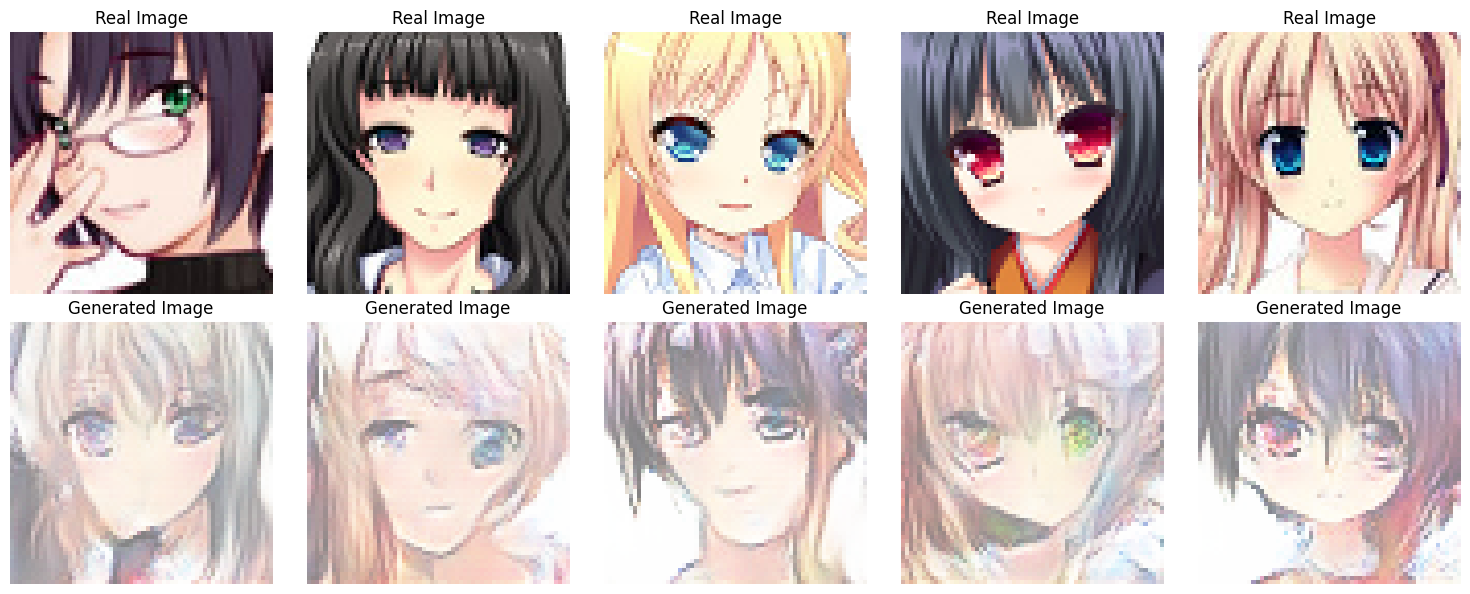

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import smart_resize, load_img, img_to_array
from scipy.linalg import sqrtm
import os
import matplotlib.pyplot as plt

# Function to calculate the FID score
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)
    real_features = model.predict(real_images)
    generated_features = model.predict(generated_images)
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    mean_diff = np.sum((mu_real - mu_generated) ** 2)
    cov_sqrt, _ = sqrtm(sigma_real.dot(sigma_generated), disp=False)
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    fid = mean_diff + np.trace(sigma_real + sigma_generated - 2.0 * cov_sqrt)
    return fid

def resize_images(images, target_size=(75, 75)):
    resized_images = np.array([smart_resize(img, target_size) for img in images])
    return resized_images

# Load the generator model
generator_model_path = "/content/drive/MyDrive/saved_models/complete_generator2_model.h5"
generator = load_model(generator_model_path)
print(f"Loaded generator model from {generator_model_path}")
print(generator.summary())  # Check the latent dimension expected by the generator

# Set the correct latent dimension
latent_dim = 300  # Adjust this based on the generator's input layer shape
num_samples = 128
random_latent_vectors = tf.random.normal(shape=(num_samples, latent_dim))

# Generate fake images using the generator
generated_images = generator.predict(random_latent_vectors)
generated_images = (generated_images * 127.5 + 127.5).astype('float32')

# Load real images from dataset
real_image_folder = '/content/data/data'  # Path to your real image dataset
image_files = [f for f in os.listdir(real_image_folder) if f.endswith('.jpg') or f.endswith('.png')]

# Limit to num_samples (128 in this case) or however many images you have
real_images = []
for image_file in image_files[:num_samples]:
    image_path = os.path.join(real_image_folder, image_file)
    img = load_img(image_path, target_size=(64, 64))  # Resize if needed
    img_array = img_to_array(img)
    real_images.append(img_array)

real_images = np.array(real_images)

# Resize both real and generated images to match InceptionV3 input size
target_size = (75, 75)
real_images_resized = resize_images(real_images, target_size)
generated_images_resized = resize_images(generated_images, target_size)

# Calculate the FID score
fid_score = calculate_fid(real_images_resized, generated_images_resized)
print(f"FID Score: {fid_score}")

# Display a few real and generated images
num_display = 5
fig, axes = plt.subplots(2, num_display, figsize=(15, 6))

# Display real images
for i in range(num_display):
    axes[0, i].imshow(real_images[i].astype('uint8'))
    axes[0, i].axis('off')
    axes[0, i].set_title("Real Image")

# Display generated images
for i in range(num_display):
    axes[1, i].imshow(generated_images[i].astype('uint8'))
    axes[1, i].axis('off')
    axes[1, i].set_title("Generated Image")

plt.tight_layout()
plt.show()


# ***Using Early Stopping and L2 normalization Techniques***
# ***MODEL_2***

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    Flatten,
    Conv2DTranspose,
    Reshape,
    BatchNormalization,
    Dropout,
    ReLU,
    LeakyReLU,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

import warnings
warnings.filterwarnings("ignore")

# Parameters
img_width, img_height = 64, 64
batch_size = 64
input_dim = 300  # Latent space dimension
epochs = 10
lr_g = 0.00015
lr_d = 0.0001
beta = 0.5
dataset_dir = "/content/data/data"  # Update with your dataset directory
save_dir = "/content/drive/MyDrive/generated_images2/"
weights_save_dir = "/content/drive/MyDrive/model_weights/"
model_save_dir = "/content/drive/MyDrive/saved_models/"

# Ensure all save directories exist
for directory in [save_dir, weights_save_dir, model_save_dir]:
    os.makedirs(directory, exist_ok=True)

def visualize_dataset(dataset):
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(dataset[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('dataset_samples.png')
    plt.close()

def plot_convergence(history):
    plt.figure(figsize=(12, 4))
    plt.title("Model Convergence")
    plt.subplot(1, 2, 1)
    plt.plot(history.history.get('d_loss', []), label='Discriminator Loss')
    plt.title('Discriminator Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history.history.get('g_loss', []), label='Generator Loss')
    plt.title('Generator Loss')
    plt.tight_layout()
    plt.savefig(f"{save_dir}/convergence_plot3.png")
    plt.close()

class WeightSavingCallback(keras.callbacks.Callback):
    def __init__(self, save_dir=weights_save_dir, prefix="dcgan"):
        super().__init__()
        self.save_dir = save_dir
        self.prefix = prefix
        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        epoch_str = f"{epoch + 1:03d}"

        # Save generator weights
        generator_path = os.path.join(
            self.save_dir,
            f"{self.prefix}_generator_weights2_epoch_{epoch_str}.weights.h5"
        )
        self.model.generator.save_weights(generator_path)
        print(f"Saved generator weights to {generator_path}")

        # Save discriminator weights
        discriminator_path = os.path.join(
            self.save_dir,
            f"{self.prefix}_discriminator_weights2_epoch_{epoch_str}.weights.h5"
        )
        self.model.discriminator.save_weights(discriminator_path)
        print(f"Saved discriminator weights to {discriminator_path}")

def load_images_from_folder(folder, target_size):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith((".png", ".jpg", ".jpeg")):
            img = keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img = keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)
    return np.array(images)

def Regularized_Generator_Model(l2_lambda=0.001):
    generator = Sequential()
    generator.add(Dense(8 * 8 * 512,
                        input_dim=input_dim,
                        kernel_regularizer=l2(l2_lambda)))
    generator.add(BatchNormalization())
    generator.add(ReLU())
    generator.add(Dropout(0.3))

    generator.add(Reshape((8, 8, 512)))

    generator.add(
        Conv2DTranspose(
            256,
            (4, 4),
            strides=(2, 2),
            padding="same",
            kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02),
            kernel_regularizer=l2(l2_lambda)
        )
    )
    generator.add(BatchNormalization())
    generator.add(ReLU())
    generator.add(Dropout(0.3))

    generator.add(Conv2DTranspose(
        128,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_regularizer=l2(l2_lambda)
    ))
    generator.add(BatchNormalization())
    generator.add(ReLU())

    generator.add(Conv2DTranspose(
        64,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_regularizer=l2(l2_lambda)
    ))
    generator.add(BatchNormalization())
    generator.add(ReLU())

    generator.add(Conv2D(3, (4, 4), padding="same", activation="sigmoid",
                         kernel_regularizer=l2(l2_lambda)))
    return generator

def Regularized_Discriminator_Model(l2_lambda=0.001):
    input_shape = (img_width, img_height, 3)
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (4, 4),
                              strides=(2, 2),
                              padding="same",
                              input_shape=input_shape,
                              kernel_regularizer=l2(l2_lambda)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(128, (4, 4),
                              strides=(2, 2),
                              padding="same",
                              kernel_regularizer=l2(l2_lambda)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Conv2D(256, (4, 4),
                              strides=(2, 2),
                              padding="same",
                              kernel_regularizer=l2(l2_lambda)))
    discriminator.add(BatchNormalization())
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Flatten())
    discriminator.add(Dense(1,
                             activation="sigmoid",
                             kernel_regularizer=l2(l2_lambda)))
    return discriminator

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=input_dim, save_dir=save_dir):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        self.save_dir = save_dir
        self.noise = tf.random.normal([num_imgs, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.noise, training=False)
        generated_images = (generated_images * 255).numpy().astype("uint8")
        plt.figure(figsize=(10, 10))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i + 1)
            plt.imshow(generated_images[i])
            plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"{self.save_dir}/generated_epoch_{epoch + 1}.png")
        plt.close()

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim=input_dim):
        super(DCGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim

        # Use named metrics for better tracking
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Discriminator training
        with tf.GradientTape() as tape:
            real_labels = tf.ones((batch_size, 1)) + 0.05 * tf.random.uniform((batch_size, 1))
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(real_labels, pred_real)

            fake_images = self.generator(random_noise)
            fake_labels = tf.zeros((batch_size, 1))
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            d_loss = (d_loss_real + d_loss_fake) / 2

        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))

        # Generator training
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.ones((batch_size, 1))
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)

        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        # Return a dictionary of metrics
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()
        }

def save_complete_models(generator, discriminator, dcgan, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    generator_path = os.path.join(save_dir, "complete_generator3_model.h5")
    generator.save(generator_path)
    print(f"Complete generator model saved to {generator_path}")

    discriminator_path = os.path.join(save_dir, "complete_discriminator3_model.h5")
    discriminator.save(discriminator_path)
    print(f"Complete discriminator model saved to {discriminator_path}")

    dcgan_path = os.path.join(save_dir, "complete_dcgan3_model.h5")
    dcgan.save(dcgan_path)
    print(f"Complete DCGAN model saved to {dcgan_path}")

def create_advanced_callbacks(patience=10, min_lr=1e-5):
    reduce_lr = ReduceLROnPlateau(
        monitor='d_loss',
        factor=0.5,
        patience=5,
        min_lr=min_lr,
        verbose=1,
        mode='min'  # Explicitly set mode to minimize loss
    )

    early_stopping = EarlyStopping(
        monitor='d_loss',
        patience=patience,
        restore_best_weights=True,
        min_delta=0.001,
        mode='min'  # Explicitly set mode to minimize loss
    )

    return [reduce_lr, early_stopping]

def calculate_fid(real_images, generated_images):
    inception_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )

    def get_activations(images):
        images = tf.image.resize(images, (299, 299))
        images = tf.keras.applications.inception_v3.preprocess_input(images * 255)
        return inception_model.predict(images)

    real_features = get_activations(real_images)
    generated_features = get_activations(generated_images)

    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    diff = mu1 - mu2

    try:
        covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    except Exception:
        return float('inf')

    if np.isnan(covmean).any():
        return float('inf')

    fid = np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2 * covmean)

    return fid

def create_loss_figure(history):
    d_loss_values = history.history.get("d_loss", [])
    g_loss_values = history.history.get("g_loss", [])
    plt.figure(figsize=(10, 6))
    plt.plot(d_loss_values, label="Discriminator Loss")
    plt.plot(g_loss_values, label="Generator Loss")
    plt.title("Generator and Discriminator Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{save_dir}/loss_plot3.png")
    plt.close()

# (Previous code remains the same)

def main():
    # Load images
    dataset = load_images_from_folder(dataset_dir, target_size=(img_width, img_height))
    print(f"Loaded {len(dataset)} images from {dataset_dir}")
    visualize_dataset(dataset)

    # Convert dataset to TensorFlow Dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(buffer_size=1024).batch(batch_size)

    # Create regularized models
    generator = Regularized_Generator_Model()
    discriminator = Regularized_Discriminator_Model()

    # Print model summaries
    print("\nGenerator Model Summary:")
    generator.summary()

    print("\nDiscriminator Model Summary:")
    discriminator.summary()

    # Create DCGAN model
    dcgan = DCGAN(generator=generator, discriminator=discriminator)

    # Compile with adaptive optimizers
    dcgan.compile(
        g_optimizer=Adam(learning_rate=lr_g, beta_1=beta),
        d_optimizer=Adam(learning_rate=lr_d, beta_1=beta),
        loss_fn=BinaryCrossentropy()
    )

    # Advanced callbacks
    callbacks = create_advanced_callbacks()
    callbacks.extend([
        DCGANMonitor(),
        WeightSavingCallback(save_dir=weights_save_dir)
    ])

    # Train with advanced techniques
    history = dcgan.fit(
        train_dataset,
        epochs=epochs,
        callbacks=callbacks
    )

    # Calculate FID score
    generated_images = generator(tf.random.normal([len(dataset), input_dim]))
    fid_score = calculate_fid(dataset, generated_images)
    print(f"Fréchet Inception Distance: {fid_score}")

    # Visualization and saving
    create_loss_figure(history)
    plot_convergence(history)

    # Save the trained models
    save_complete_models(generator, discriminator, dcgan, model_save_dir)

    return dcgan, history, fid_score

if __name__ == "__main__":
    # Run the main training script
    try:
        dcgan, training_history, fid = main()
        print("Training completed successfully!")
    except Exception as e:
        print(f"An error occurred during training: {e}")
        import traceback
        traceback.print_exc()


Loaded 21551 images from /content/data/data

Generator Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 32768)               │       9,863,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32768)               │         131,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 16, 16, 256)         │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 3)           │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,752,067 (48.65 MB)

 Trainable params: 12,685,635 (48.39 MB)

 Non-trainable params: 66,432 (259.50 KB)


Discriminator Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 677,057 (2.58 MB)

 Trainable params: 676,161 (2.58 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - d_loss: -0.4453 - g_loss: 0.0431Saved generator weights to /content/drive/MyDrive/model_weights/dcgan_generator_weights2_epoch_001.weights.h5
Saved discriminator weights to /content/drive/MyDrive/model_weights/dcgan_discriminator_weights2_epoch_001.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - d_loss: -0.4473 - g_loss: 0.0430 - learning_rate: 0.0010
Epoch 2/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - d_loss: -0.6678 - g_loss: 0.0450Saved generator weights to /content/drive/MyDrive/model_weights/dcgan_generator_weights2_epoch_002.weights.h5
Saved discriminator weights to /content/drive/MyDrive/model_weights/dcgan_discriminator_weights2_epoch_002.weights.h5
337/337 ━━━━━━━━━━━━━━━━━━━━ 105s 139ms/step - d_loss: -0.6680 - g_loss: 0.0451 - learning_rate: 0.0010
Epoch 3/10
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - d_loss: -1.3384 - g_loss: 0.9742Saved generator weights to /content/drive/MyDrive/model_weights/dcgan_gen

Traceback (most recent call last):
  File "<ipython-input-2-bc73e8c85e9a>", line 413, in <cell line: 410>
    dcgan, training_history, fid = main()
  File "<ipython-input-2-bc73e8c85e9a>", line 397, in main
    generated_images = generator(tf.random.normal([len(dataset), input_dim]))
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 53, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.ResourceExhaustedError: Exception encountered when calling Conv2DTranspose.call().

{{function_node __wrapped__Conv2DBackpropInput_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[21551,16,16,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [